# Clustering Exercises: Exploratory Analysis
<hr style="border:2px solid black">

## Imports:

In [225]:
##### Imports
import env

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle_zillow as wr

# Statistical Tests
from scipy import stats

# Visualizing
import matplotlib.pyplot as plt
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = (-1_000_000, 1_000_000)
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

<hr style="border:2px solid black">

## Acquire

In [226]:
# acquire
zillow_acquire = wr.acquire_zillow()

<hr style="border:2px solid black">

## Prepare

In [227]:
zillow_single_unit = wr.drop_multi_fam(zillow_acquire)

In [228]:
z_single_unit_handled_missing = wr.handle_missing_values(zillow_single_unit, .80, .80)
z_single_unit_handled_missing.shape

(52271, 26)

In [229]:
# sort by tax_value
z_sorted = z_single_unit_handled_missing.sort_values(by='taxvaluedollarcnt', ascending=True)

# calculate the number of rows in the top and bottom 0.5%
num_rows = int(0.005 * len(z_sorted))
# remove the top and bottom .5% of rows

z_outliers_removed = z_sorted.iloc[num_rows:-num_rows]

In [230]:
# split in to train, validate, test (65/25/20)
train, validate, test = wr.split_data(z_outliers_removed)

In [231]:
z_outliers_removed.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc'],
      dtype='object')

<hr style="border:2px solid black">

## Explore

### Q1. What is the distribution of each variable?

In [232]:
# look at the columns in our df and choose which to explore
print(z_outliers_removed.columns)

explore_cols = [
        'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'yearbuilt', 'taxvaluedollarcnt', 'logerror', 'fullbathcnt'
]

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc'],
      dtype='object')


In [233]:
z = z_outliers_removed[explore_cols]

In [234]:
cat_feats = ['assessmentyear','fips']
continuous_feats = [explore_cols]

In [235]:
fig, axs = plt.subplots(4, 2, figsize=(60, 120))
fig.suptitle('Distribution of Features', fontsize=30)

for i in range(4):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(train[explore_cols[i * 2 + j]])
        ax.set_title(label=f'{explore_cols[i * 2 + j]}', fontsize=50)
        
        # Increase font size of xticks and yticks
        ax.tick_params(axis='x', labelsize=40)
        ax.tick_params(axis='y', labelsize=40)

plt.show()

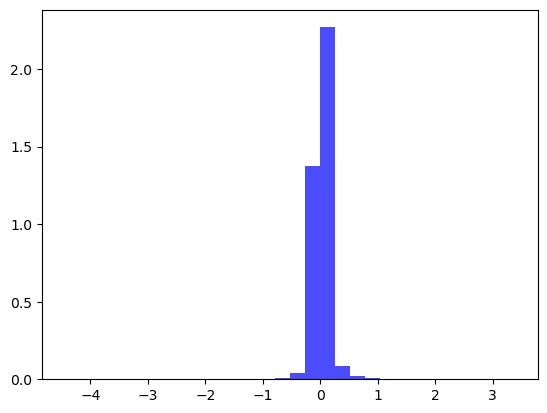

In [236]:
plt.hist(train.logerror, bins=30, density=True, alpha=0.7, color='blue')
plt.show()

> ### Takeaways:
> * bathroomcnt, bedroomcnt, yearbuilt: Normally Distributed 
> * calculatedfinishedsquarefeet: Somewhat normally distributed, right skewed
> * taxvaluedollarcnt: Heavily skewed to the right
> * fips: about 2/3 of observations are in 6040
> * logerror: Normal distribution. Very Dense.

### Q2. Is logerror significantly different for properties below the median tax value or above the median?

In [237]:
# find median of taxvaluedollarcnt
median_value = train.taxvaluedollarcnt.median()

# create the 'percentile' column
train['percentile'] = np.where(train.taxvaluedollarcnt < median_value, 'bottom_50', 'top_50')

<Axes: xlabel='logerror', ylabel='percentile'>

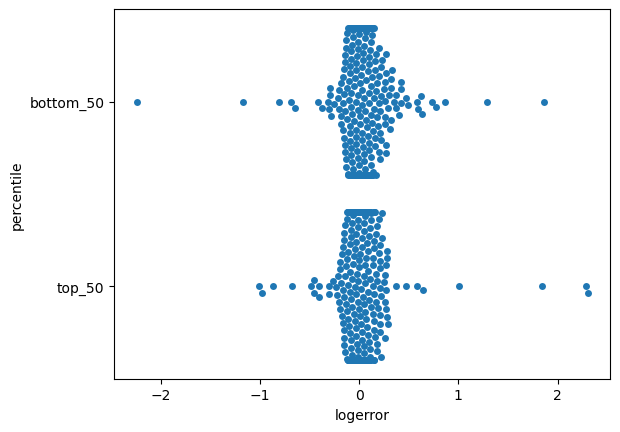

In [238]:
sns.swarmplot(data=train.sample(1500), y='percentile', x='logerror')

> Thoughts: It doesn't look like there is a significant difference between the groups. 

Stats Test:
* continuous x categorical: Comparing Means
* Normally distributed: t-test


Levene Test
* Ho: the variances are equal
* Ha: the variances are different
alpha = 0.5

In [239]:
stats.levene(train[train.percentile=='bottom_50'].logerror,
             train[train.percentile=='top_50'].logerror)

LeveneResult(statistic=22.933662219000578, pvalue=1.6851720048444297e-06)

Hypothesis Test: 2-sample, 2-tail, Mannwhitneyu

H0: There is no difference in the mean logerror between the bottom 50% of tax values and the top 50% of tax values. \
Ha: There is a significant difference in the mean logerror between the bottom 50% of tax values and the top 50% of tax values.

In [240]:
# p is lower than our alpha, we reject the null, suggesting we have unequal variance and must use a non parametric test (mann whitney)
stats.mannwhitneyu(train[train.percentile=='bottom_50'].logerror,
             train[train.percentile=='top_50'].logerror)

MannwhitneyuResult(statistic=103934185.0, pvalue=0.14466756005697598)

#### Takeaway
* There is a significant difference in logerror between to bottom half and top half of home values.

### Q3. Is there a relationship betwen logerror and sqft?

In [241]:
logerr_squar_df = train.copy()
logerr_squar_df['absolute_error'] = (((logerr_squar_df.logerror) * (logerr_squar_df.logerror)) ** .5)

<Axes: xlabel='logerror', ylabel='calculatedfinishedsquarefeet'>

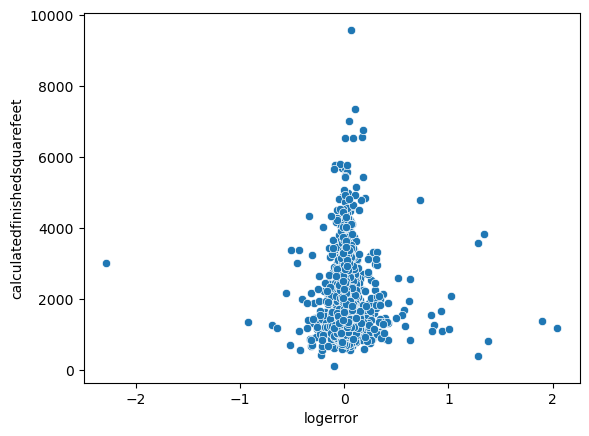

In [242]:
sns.scatterplot(data=train.sample(2000), x='logerror', y='calculatedfinishedsquarefeet')

<Axes: xlabel='calculatedfinishedsquarefeet', ylabel='absolute_error'>

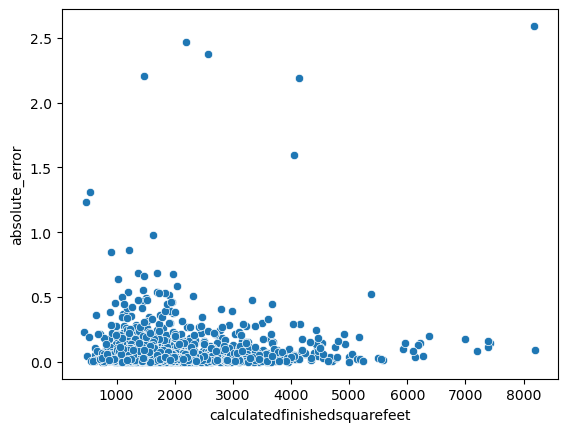

In [243]:
sns.scatterplot(data=logerr_squar_df.sample(2000), y='absolute_error', x='calculatedfinishedsquarefeet')

> It looks like the magnitude of logerror is highest as sqft is lower, but this is likely just because of the distribution of sqft being right-skewed and the density of the logerror distribution.

Stats Test:
* continuous x continuous: correlation
* sqft not normally distributed: will use spearman because i want to check for a monotonic relationship


Hypothesis Test: Spearman R \
H0: There is no linear correlation between logerror and sqft \
Ha: There is a linear correlation between logerror and sqft

In [244]:
stats.spearmanr(train.calculatedfinishedsquarefeet, train.logerror, nan_policy='omit')

SignificanceResult(statistic=0.07095925869745809, pvalue=1.231407105438955e-33)

#### Takeaway
* There is a monotonic correlation between logerror and sqft.

### Q4. Is magnitude of logerror significantly different for properties older than the median yearbuilt (1961) than properties newer than the median yearbuilt?

In [245]:
# find median of yearbuilt
median_yearbuild = train.yearbuilt.median()

# create the 'prop_age' column
train['prop_age'] = np.where(train.yearbuilt <= median_yearbuild, 'older_than_1961', 'newer_than_1961')
logerr_squar_df['prop_age'] = np.where(logerr_squar_df.yearbuilt <= median_yearbuild, 'older_than_1961', 'newer_than_1961')

<Axes: xlabel='prop_age', ylabel='logerror'>

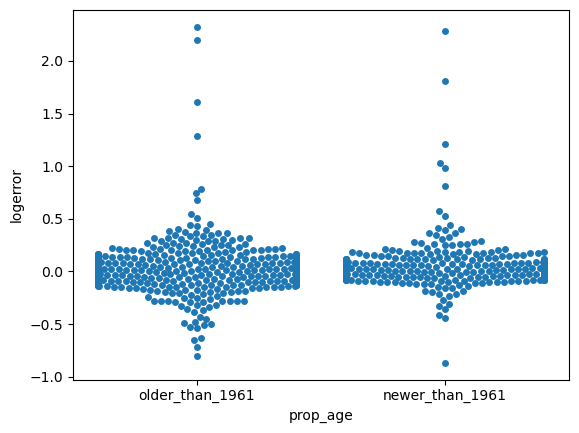

In [246]:
sns.swarmplot(data=logerr_squar_df.sample(2000), y='logerror', x='prop_age')

<Axes: xlabel='prop_age', ylabel='absolute_error'>

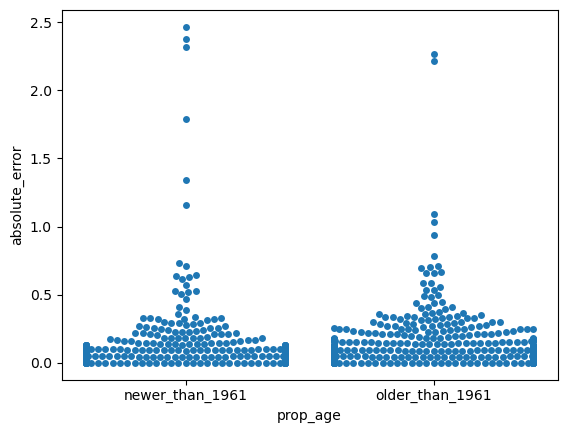

In [247]:
sns.swarmplot(data=logerr_squar_df.sample(2000), y='absolute_error', x='prop_age')

Stats Test: 
* continuous x categorical: Comparing Means
* normal distribuiton
* Use leven test to check for equal variances

In [248]:
# Levene Test
stats.levene(logerr_squar_df[logerr_squar_df.yearbuilt <= 1961].absolute_error,
             logerr_squar_df[logerr_squar_df.yearbuilt > 1961].absolute_error)

LeveneResult(statistic=115.14818675902713, pvalue=8.203603538609409e-27)

> Our pvalue is less than alpha, therefore we reject the null hypothesis;
> Our variances are not equal

Hypothesis: \
H0: Absolute logerror is independent of whether a house was built prior to 1961 or after. \
Ha: Absolute logerror has a dependent relationship with whether a house was built prior to 1961 or after.

In [249]:
# t-test of independence
stats.ttest_ind(logerr_squar_df[logerr_squar_df.yearbuilt <= 1961].absolute_error,
             logerr_squar_df[logerr_squar_df.yearbuilt > 1961].absolute_error,
             equal_var=False)

Ttest_indResult(statistic=13.00271152396075, pvalue=1.5161471630075843e-38)

> We can reject our null hypothesis. There is a dependent relationship between the age of the home and absolute logerror.

### Q5. Is mean absolute logerror significantly greater for homes built before 1961 than homes after 1961?

Hypothesis: \
H0: Mean absolute logerror of houses built during 1961 or older is <= Mean absolute logerror of houses built after 1961. \
Ha: Mean absolute logerror of houses built during 1961 or older is > Mean absolute logerror of houses built after 1961.

In [250]:
t, p = stats.ttest_ind(logerr_squar_df[logerr_squar_df.yearbuilt <= 1961].absolute_error,
             logerr_squar_df[logerr_squar_df.yearbuilt > 1961].absolute_error,
             equal_var=False,
             alternative='greater')
t, p

(13.00271152396075, 7.580735815037921e-39)

In [251]:
alpha = 0.5
if p / 2 > alpha:
    print("We fail to reject the null hypothesis")
elif t < 0:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


> Mean absolute logerror is significantly greater for houses built prior to 1962.